In [47]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import glob


### test for the way shift and taking a diff between arr - arr.shift() works 

In [48]:

import numpy as np
from scipy.ndimage import shift

# xs = np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

# shift(xs, 1)#, cval=np.NaN)

arr1 = np.array([2, 3, 4, 5, 6, 7])
# arr2 = [1, 2, 3, 4, 5, 6]

arr1sh = shift(arr1, 1)

diff = arr1 - arr1sh


In [49]:
print(arr1)
print(arr1sh)
print(diff)

[2 3 4 5 6 7]
[0 2 3 4 5 6]
[2 1 1 1 1 1]


## loop over years, append together 

In [50]:
# read all data

directory = '/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/testera5land/ncfiles/'
files = glob.glob(directory + '*.nc')

In [51]:
# create an empty dataset to append new values to 


# Define the dimensions and coordinates (you can adjust these to your needs)
dims = ('time', 'latitude', 'longitude')
coords = {
    'time': [],
    'latitude': [],
    'longitude': [],
    # Add more coordinates as needed
}

# Create an empty xarray dataset with empty data variables
empty_dataset = xr.Dataset(
    {
        'tp': (dims, np.nan * np.empty((0, 0, 0))),  
    },
    coords=coords
)

# empty_dataset


In [52]:
# define function 
def calculate_hourly_diff(arr):
    ''' calculate difference''' 
    diff = arr - arr.shift(time=1, fill_value=0)
    return xr.DataArray(diff, coords=arr.coords)

# run for every file in the directory: 
for i in files: 
    i = xr.open_dataset(i)
    
    i['tp'] = i.tp.where(i.tp >= 0, 0)
    
    i = i.shift(time = -1, fill_value = 0)
    values = i.tp.groupby('time.dayofyear').apply(calculate_hourly_diff)
    new_data = xr.Dataset({'tp': values})
    
    # after you run a "year", append to the "empty_data" to fill it 
    empty_dataset = xr.concat([empty_dataset, new_data], dim='time')

    
empty_dataset = empty_dataset.sortby('time')

In [54]:
''' empty_dataset - this is your xarray dataset with ''normal'' hourly values''' 

# empty_dataset

" empty_dataset - this is your xarray dataset with ''normal'' hourly values"

# play around with time series to look at how data actually looks like

In [55]:
cut_coords = empty_dataset.sel(latitude=29.0, longitude=84.0, method='nearest')

# slice data - take a day  
start_date = '2020-12-30T00:00:00.000000000'
end_date   = '2021-01-10T23:00:00.000000000'

# Slice the dataset for a day 
cut_time = cut_coords.sel(time=slice(start_date, end_date))


<xarray.DataArray 'tp' ()>
array(-1.50129199e-06)
Coordinates:
    latitude   float64 29.0
    longitude  float64 84.0

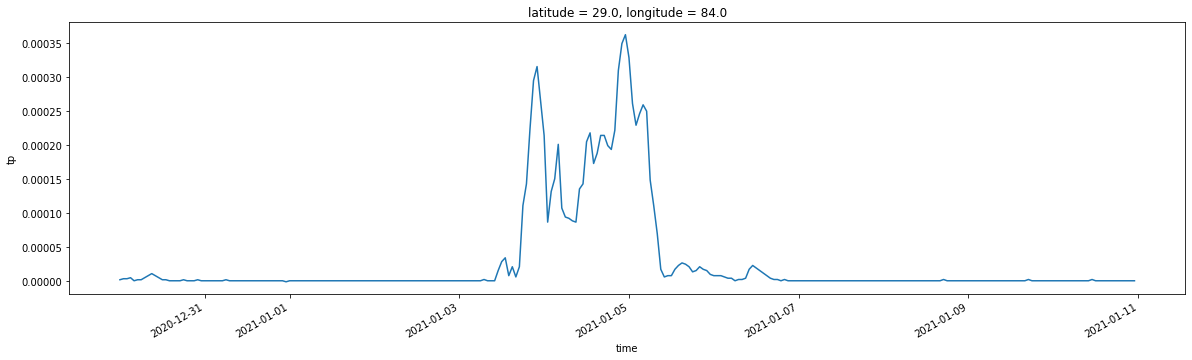

In [56]:
plt.figure(figsize = (20, 5))
cut_time.tp.plot()

# all ts 
# cut_coords.tp.plot() # is last value negative? cut it out 

cut_time.tp.min()



In [57]:
cut_timedf = cut_time.to_dataframe()

In [58]:
cut_timedf.tp.min()

# Find the row with the minimum value in the 'tp' column
minrow = cut_timedf[cut_timedf['tp'] == cut_timedf['tp'].min()]

# If there are multiple rows with the minimum value, you can select the first one
minrow.iloc[0]


latitude     29.000000
longitude    84.000000
tp           -0.000002
Name: 2020-12-31 23:00:00, dtype: float64

# all sort of tests to see if its correct

In [59]:
# # read all data

directory = '/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/testera5land/ncfiles/'
files = glob.glob(directory + '*.nc')

# Use xarray.open_mfdataset to open and concatenate the .nc files
data = xr.open_mfdataset(files)
data = data.sortby('time')
# data['tp'] = data.tp * 1000 # check units

# shift 1 time step back 
data = data.shift(time= -1, fill_value=0).sortby('time')


In [60]:
''' calculate the sum within day in a shifted data, compare with the max within the same day in the original data '''
# slice coordinates
data_coords= data.sel(latitude=29.0, longitude=84.0, method='nearest')
data_time = data_coords.sel(time=slice(start_date, end_date))


### plot together 

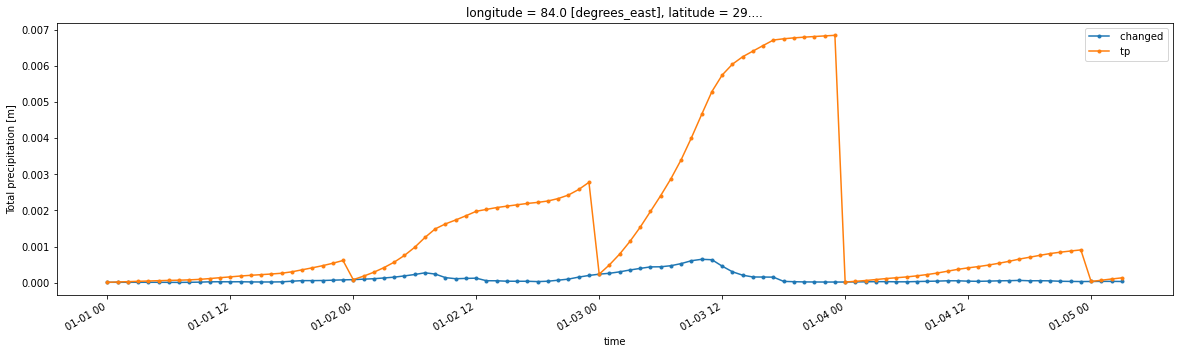

In [61]:
plt.figure(figsize = (20, 5))
cut_coords.tp[:100].plot(label = ' changed', marker = '.')
data_coords.tp[:100].plot(label = ' tp', marker = '.')

plt.legend()

### calculate sum/max for a day

In [62]:
# slice data - take a day  
start_date = '2020-12-31T00:00:00.000000000'
end_date = '2020-12-31T23:00:00.000000000'

# Slice the dataset for a day 
cut_time = cut_coords.sel(time=slice(start_date, end_date))
data_time = data_coords.sel(time=slice(start_date, end_date))

print('new hourly data - daily sum:', round(cut_time.tp.values.sum(), 6))
print('original data - daily max (cumulative sum):', round(data_time.tp.values.max(), 6))



new hourly data - daily sum: 0.0
original data - daily max (cumulative sum): 2e-06


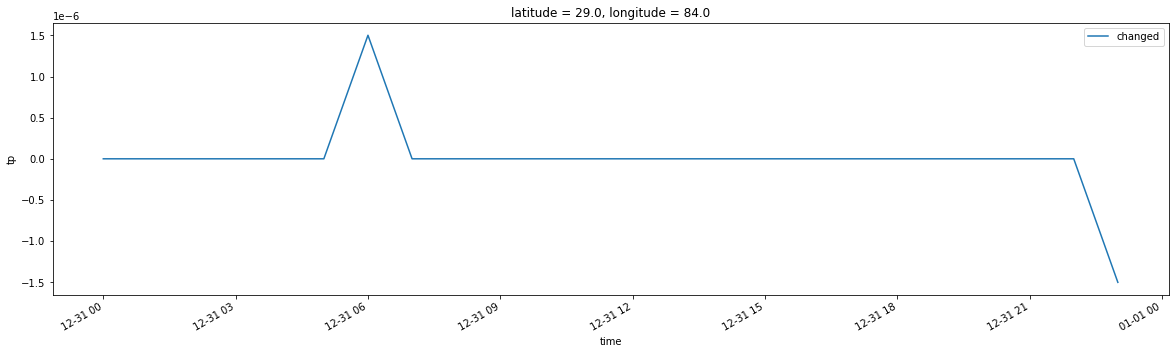

In [63]:
plt.figure(figsize = (20, 5))
cut_time.tp.plot(label = 'changed')
# data_time.tp[:1000].plot(label = 'tp')

plt.legend()

## data one by one 

In [64]:
# open just one file, look what are the values for first and last days of year 

data2020 = xr.open_dataset('/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/testera5land/ncfiles/2020.nc').sel(latitude=29.0, longitude=84.0, method='nearest').shift(time = -1)
data2021 = xr.open_dataset('/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/testera5land/ncfiles/2021.nc').sel(latitude=29.0, longitude=84.0, method='nearest').shift(time = -1)
data2022 = xr.open_dataset('/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/testera5land/ncfiles/2022.nc').sel(latitude=29.0, longitude=84.0, method='nearest').shift(time = -1)


In [65]:
start0 = '2020-01-01T00:00:00.000000000'
end0  = '2020-01-02T23:00:00.000000000'
data2020_cut = data2020.sel(time = slice(start0, end0))

start1 = '2021-06-30T00:00:00.000000000'
end1  = '2021-12-31T23:00:00.000000000'
data2021_cut = data2021.sel(time = slice(start1, end1))

start2 = '2022-01-01T00:00:00.000000000'
end2   = '2022-01-02T23:00:00.000000000'
data2022_cut = data2022.sel(time = slice(start2, end2))

In [ ]:
newdata = empty_dataset.sel(latitude=29.0, longitude=84.0, method='nearest').sortby('time')
newdata1 = newdata.sel(time = slice(start1, end1))

In [ ]:
plt.figure(figsize = (10, 5))
data2021_cut.tp.plot(label = 'tp')
newdata1.precipitation.plot(label = 'newdata')

plt.legend()

In [ ]:
newdatadf = newdata.to_dataframe()
newdatadf[:25]

In [ ]:
data2020df = data2020.to_dataframe()
data2020df[:25]

In [ ]:
plt.figure(figsize = (20, 5))

# data2020df.tp[:200].plot(label = 'data 2020')
newdatadf.precipitation[:20000].plot(label = 'new data')



## convert to dataframe to see what is goin on 

In [72]:
newdatadf = empty_dataset.to_dataframe()


# Filter and print rows with negative values in the selected column
negative_rows = newdatadf[newdatadf.tp < 0]
print("Rows with negative values:")

negative_rows

Rows with negative values:


tp
latitude longitude time                         
29.4     83.400002 2020-12-31 23:00:00 -0.000002
                   2021-12-31 23:00:00 -0.000002
                   2022-01-13 17:00:00 -0.000001
                   2022-12-31 23:00:00 -0.000026
         83.500000 2020-12-31 23:00:00 -0.000002
...                                          ...
28.5     84.199997 2021-12-31 23:00:00 -0.000358
                   2022-12-31 23:00:00 -0.002130
         84.300003 2020-12-31 23:00:00 -0.000002
                   2021-12-31 23:00:00 -0.000360
                   2022-12-31 23:00:00 -0.002031

[351 rows x 1 columns]

In [73]:
negative_rows.tp.min()



-0.00995861366391182

In [74]:
negative_rows = negative_rows.reset_index()

In [75]:
negative_rows['hour'] = negative_rows.time.dt.hour

In [76]:
negative_rows['hour'].unique()

array([23, 17, 18, 16, 19, 14,  4, 20,  5, 12, 15, 13, 22, 21,  9, 11,  6,
       10,  8])

In [77]:
negative_rows1 = negative_rows[negative_rows.hour == 5]

In [78]:
len(negative_rows)


351